In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os
import subprocess
# Add parent directory to path
sys.path.append('..')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print(" Environment setup complete")

 Environment setup complete


In [ ]:
import yfinance as yf
tickers = ['AAPL', 'MSFT', 'AMZN']  # From options files
start_date = '2025-10-01'
end_date = '2026-01-31'  # Day after last options date

print(f"Fetching underlying prices for {', '.join(tickers)}")
print(f"   Date range: {start_date} to {end_date}\n")

all_data = []
for ticker in tickers:
    try:
        print(f"   Downloading {ticker}...", end=' ')
        data = yf.download(ticker, start=start_date, end=end_date, 
                          progress=False, auto_adjust=True)
        
        if not data.empty:
            data = data.reset_index()
            data['ticker'] = ticker
            
            # Flatten columns if MultiIndex
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
            
            all_data.append(data)
            print(f"OK - {len(data)} days")
        else:
            print(f"No data")
    except Exception as e:
        print(f"Error: {e}")

if all_data:
    prices_df = pd.concat(all_data, ignore_index=True)
    column_map = {'Date': 'date', 'Open': 'open', 'High': 'high', 
                  'Low': 'low', 'Close': 'close', 'Volume': 'volume'}
    prices_df = prices_df.rename(columns=column_map)
    prices_df = prices_df.sort_values(['ticker', 'date'])
    prices_df['return_1d'] = prices_df.groupby('ticker')['close'].pct_change()
    prices_df['return_5d'] = prices_df.groupby('ticker')['close'].pct_change(5)
    prices_df['volatility_30d'] = prices_df.groupby('ticker')['return_1d'].transform(
        lambda x: x.rolling(30, min_periods=10).std() * np.sqrt(252)
    )
    output_file = '../data/underlying_prices/underlying_prices.csv'
    prices_df.to_csv(output_file, index=False)
    
    print(f"\nFETCHED AND SAVED UNDERLYING PRICES")
    print(f"   File: {output_file}")
    print(f"   Shape: {prices_df.shape}")
    print(f"   Tickers: {sorted(prices_df['ticker'].unique())}")
    print(f"   Date range: {prices_df['date'].min().date()} to {prices_df['date'].max().date()}")
    print(f"   Total days: {prices_df['date'].nunique()}")
    
    print(f"\nSAMPLE:")
    display(prices_df.head(3))
else:
    print("\nFailed to fetch any price data")
    prices_df = None

Fetching underlying prices for AAPL, MSFT, AMZN
   Date range: 2025-10-01 to 2026-01-31


FETCHED AND SAVED UNDERLYING PRICES
   File: ../data/underlying_prices/underlying_prices.csv
   Shape: (252, 10)
   Tickers: ['AAPL', 'AMZN', 'MSFT']
   Date range: 2025-10-01 to 2026-01-30
   Total days: 84

SAMPLE:


,date,close,high,low,open,volume,ticker,return_1d,return_5d,volatility_30d
0,2025-10-01,254.964035,258.297693,254.445020,254.554811,48713900,AAPL,NaN,NaN,NaN
1,2025-10-02,256.640839,257.688829,253.666497,256.091867,42630200,AAPL,0.006577,NaN,NaN
2,2025-10-03,257.529144,258.746825,253.466895,254.185526,49155600,AAPL,0.003461,NaN,NaN


## 1. Load Underlying Price Data

In [ ]:
# Load options data
try:
    import glob
    
    # Find all options data files
    options_files = glob.glob('../data/options_data/*_Options_Data.csv')
    
    if not options_files:
        raise FileNotFoundError("No options data files found in ../data/options_data/")
    
    print(f"Found {len(options_files)} options data files:")
    
    # Load and combine all files, checking for column consistency
    dfs = []
    for file in options_files:
        df = pd.read_csv(file)
        ticker_name = Path(file).stem.split('_')[0]
        
        # Check if ts_event column exists
        if 'ts_event' not in df.columns:
            print(f"        {Path(file).name}: MISSING ts_event column - SKIPPING this file")
            print(f"       (This file has {len(df):,} rows that will be excluded)")
            continue
        
        print(f"   OK - {Path(file).name}: {len(df):,} rows")
        dfs.append(df)
    
    if not dfs:
        raise ValueError("No valid options data files found (all missing ts_event column)")
    
    # Concatenate all valid dataframes
    options_df = pd.concat(dfs, ignore_index=True)
    
    # Handle timestamp conversion
    if 'ts_event' in options_df.columns:
        options_df['date'] = pd.to_datetime(options_df['ts_event'])
    elif 'date' in options_df.columns:
        options_df['date'] = pd.to_datetime(options_df['date'])
    else:
        raise ValueError("No timestamp column found")
    
    # Extract ticker from symbol if not present
    if 'ticker' not in options_df.columns and 'symbol' in options_df.columns:
        options_df['ticker'] = options_df['symbol'].str.strip().str.split().str[0]
    
    # Remove any rows with missing dates (should be none now)
    initial_rows = len(options_df)
    options_df = options_df[options_df['date'].notna()].copy()
    dropped_rows = initial_rows - len(options_df)
    
    print(f"\n OPTIONS DATA LOADED")
    print(f"   Shape: {options_df.shape}")
    print(f"   Tickers: {sorted(options_df['ticker'].unique())}")
    print(f"   Date range: {options_df['date'].min().date()} to {options_df['date'].max().date()}")
    print(f"   Columns: {list(options_df.columns)}")
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows:,} rows with missing timestamps")
    
    # Check for NaN values in numerical columns
    print(f"\n DATA QUALITY:")
    numerical_cols = ['open', 'high', 'low', 'close', 'volume']
    null_counts = options_df[numerical_cols].isnull().sum()
    total_nulls = null_counts.sum()
    
    if total_nulls > 0:
        print(f"Found {total_nulls:,} NaN values in price/volume data:")
        for col, count in null_counts[null_counts > 0].items():
            print(f"      {col}: {count:,} ({count/len(options_df)*100:.1f}%)")
    else:
        print(f"   No missing values in price/volume columns")
    
    # Show sample data
    print(f"\n SAMPLE DATA (first 5 rows):")
    display(options_df.head(5)[['date', 'ticker', 'symbol', 'open', 'high', 'low', 'close', 'volume']])
    
    # Show statistics
    print(f"\n SUMMARY STATS:")
    print(f"   Records per ticker:")
    for ticker, count in options_df.groupby('ticker').size().sort_values(ascending=False).items():
        print(f"      {ticker}: {count:,}")
    print(f"   Volume: min={options_df['volume'].min()}, max={options_df['volume'].max():,}, mean={options_df['volume'].mean():.1f}")
    print(f"   Close: min=${options_df['close'].min():.2f}, max=${options_df['close'].max():.2f}, mean=${options_df['close'].mean():.2f}")
    
except Exception as e:
    print(f" Error loading options: {e}")
    print("   Check data files or re-run data acquisition")
    import traceback
    traceback.print_exc()
    options_df = None

Found 3 options data files:
   ✓ MSFT_Options_Data.csv: 800,516 rows
   ✓ AAPL_Options_Data.csv: 704,124 rows
   ✓ AMZN_Options_Data.csv: 812,784 rows

 OPTIONS DATA LOADED
   Shape: (2317424, 12)
   Tickers: ['AAPL', 'AMZN', 'MSFT']
   Date range: 2025-10-01 to 2026-01-30
   Columns: ['ts_event', 'rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'date', 'ticker']

 DATA QUALITY:
   ✓ No missing values in price/volume columns

 SAMPLE DATA (first 5 rows):


,date,ticker,symbol,open,high,low,close,volume
0,2025-10-01 00:00:00+00:00,MSFT,MSFT 260220C00520000,34.37,34.37,34.37,34.37,2
1,2025-10-01 00:00:00+00:00,MSFT,MSFT 260220C00520000,33.30,36.15,33.30,36.15,4
2,2025-10-01 00:00:00+00:00,MSFT,MSFT 251010P00492500,1.19,1.19,0.69,0.71,7
3,2025-10-01 00:00:00+00:00,MSFT,MSFT 251010P00492500,1.16,1.16,1.04,1.04,2
4,2025-10-01 00:00:00+00:00,MSFT,MSFT 261218P00605000,97.45,97.45,97.45,97.45,1



 SUMMARY STATS:
   Records per ticker:
      AMZN: 812,784
      MSFT: 800,516
      AAPL: 704,124
   Volume: min=1, max=200,041, mean=67.7
   Close: min=$0.01, max=$425.90, mean=$18.18


## 2. Underlying Price Analysis

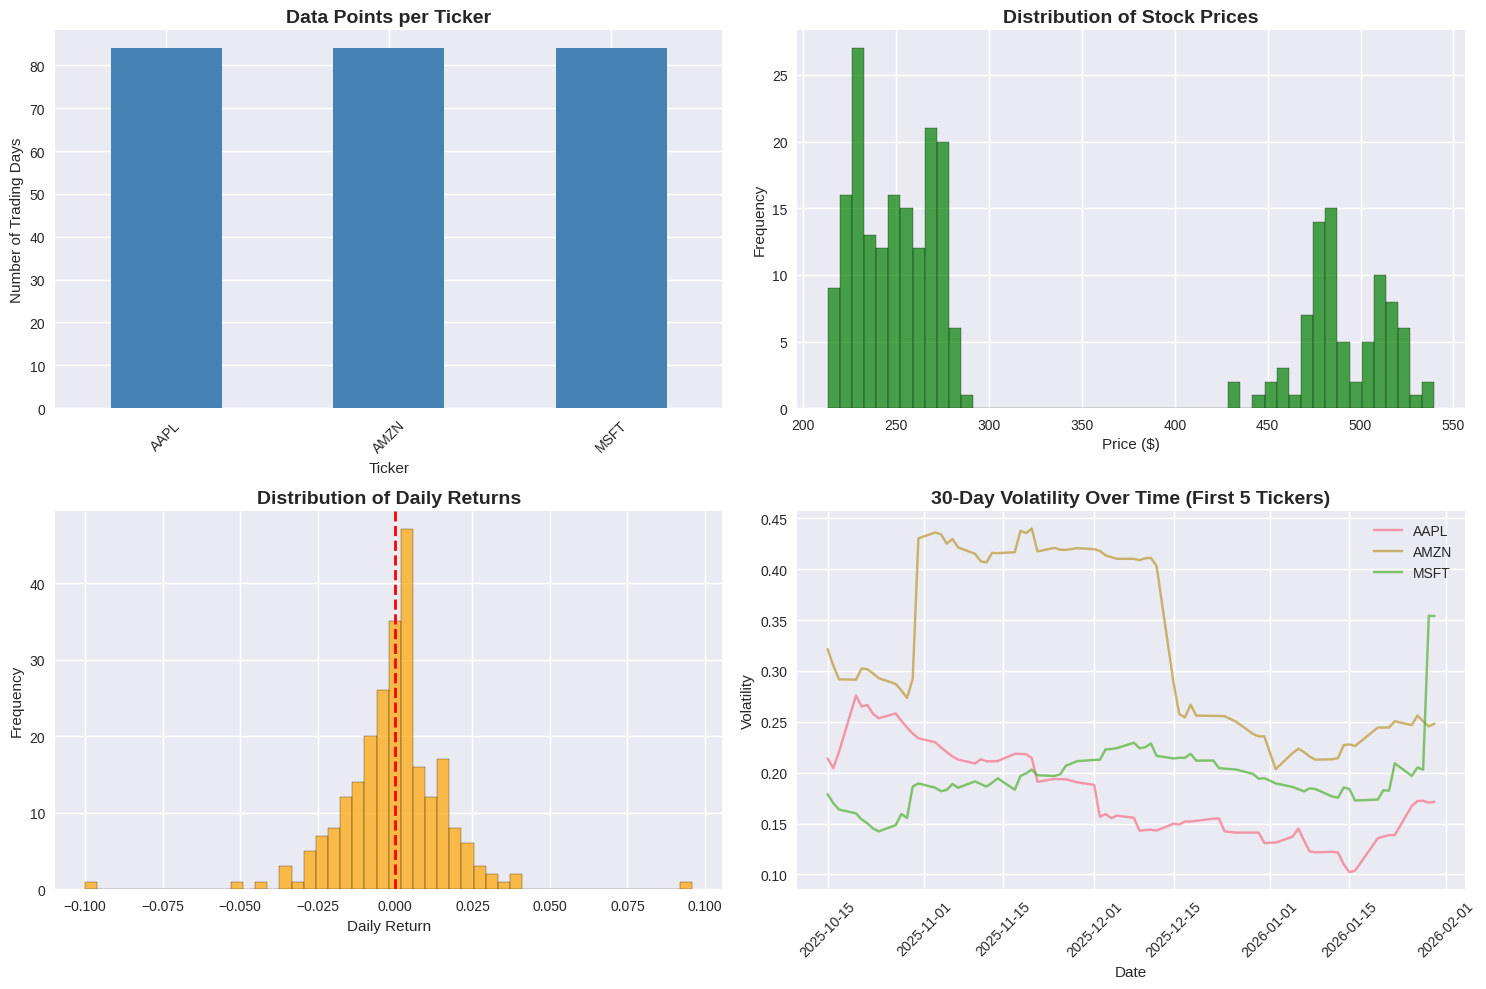


 PRICE STATISTICS:
   Total records: 252
   Unique tickers: 3
   Avg trading days/ticker: 84
   Price range: $213.04 - $539.83
   Avg daily return: -0.022%
   Daily return std: 1.644%


In [10]:
if prices_df is not None:
    # Ticker coverage
    ticker_counts = prices_df.groupby('ticker').size().sort_values(ascending=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Ticker coverage
    ticker_counts.plot(kind='bar', ax=axes[0,0], color='steelblue')
    axes[0,0].set_title('Data Points per Ticker', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Ticker')
    axes[0,0].set_ylabel('Number of Trading Days')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Price distribution
    axes[0,1].hist(prices_df['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Distribution of Stock Prices', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Price ($)')
    axes[0,1].set_ylabel('Frequency')
    
    # 3. Daily returns distribution
    axes[1,0].hist(prices_df['return_1d'].dropna(), bins=50, color='orange', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Daily Return')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(0, color='red', linestyle='--', linewidth=2)
    
    # 4. Volatility over time
    if 'volatility_30d' in prices_df.columns:
        vol_data = prices_df[prices_df['volatility_30d'].notna()]
        for ticker in vol_data['ticker'].unique()[:5]:  # Plot first 5 tickers
            ticker_data = vol_data[vol_data['ticker'] == ticker].sort_values('date')
            axes[1,1].plot(ticker_data['date'], ticker_data['volatility_30d'], label=ticker, alpha=0.7)
        axes[1,1].set_title('30-Day Volatility Over Time (First 5 Tickers)', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Volatility')
        axes[1,1].legend(loc='best')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n PRICE STATISTICS:")
    print(f"   Total records: {len(prices_df):,}")
    print(f"   Unique tickers: {prices_df['ticker'].nunique()}")
    print(f"   Avg trading days/ticker: {ticker_counts.mean():.0f}")
    print(f"   Price range: ${prices_df['close'].min():.2f} - ${prices_df['close'].max():.2f}")
    if 'return_1d' in prices_df.columns:
        print(f"   Avg daily return: {prices_df['return_1d'].mean()*100:.3f}%")
        print(f"   Daily return std: {prices_df['return_1d'].std()*100:.3f}%")

## 3. Options Data Analysis

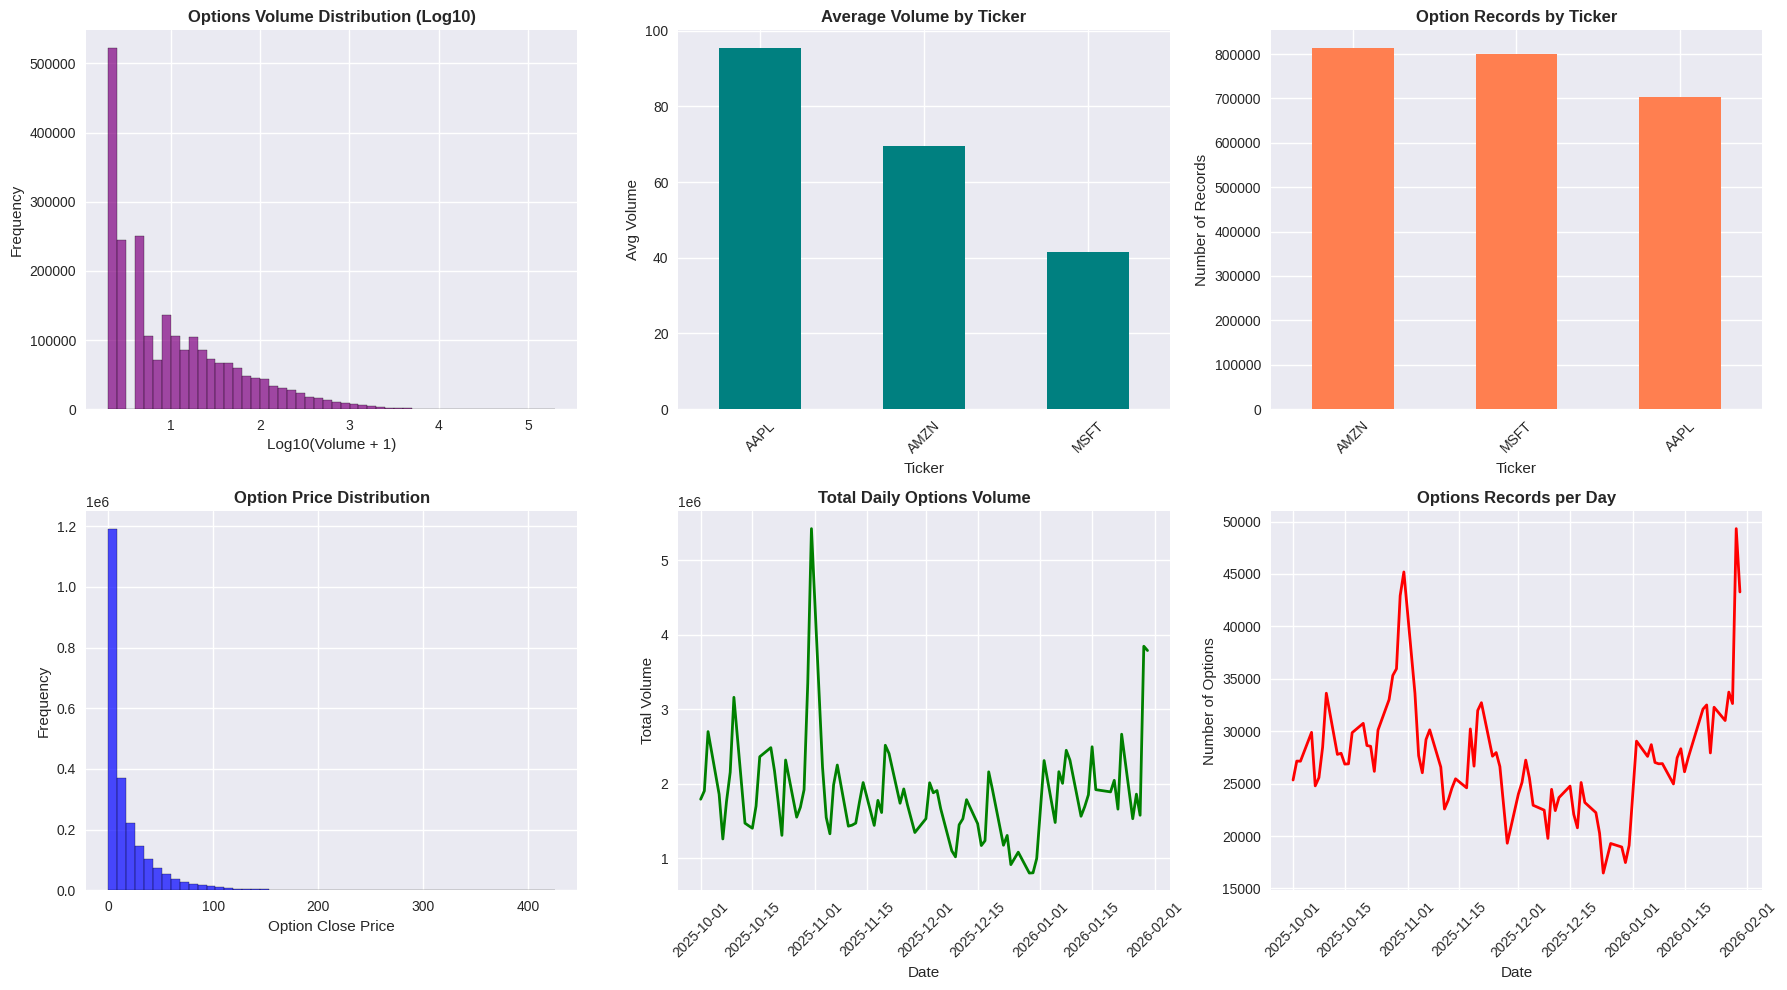


 OPTIONS STATISTICS:
   Total option records: 2,317,424
   Unique tickers: 3
   Date range: 84 days
   Avg options/day: 27588

   Volume Stats:
      Mean: 67.7
      Median: 6.0
      75th percentile: 27.0
      Max: 200041

   Price Stats:
      Mean: $18.18
      Median: $8.00
      Range: $0.01 - $425.90


In [11]:
if options_df is not None:
    # Options characteristics
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Volume distribution (log scale)
    axes[0,0].hist(np.log10(options_df['volume'] + 1), bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Options Volume Distribution (Log10)', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Log10(Volume + 1)')
    axes[0,0].set_ylabel('Frequency')
    
    # 2. Volume by ticker
    vol_by_ticker = options_df.groupby('ticker')['volume'].mean().sort_values(ascending=False)
    vol_by_ticker.plot(kind='bar', ax=axes[0,1], color='teal')
    axes[0,1].set_title('Average Volume by Ticker', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Ticker')
    axes[0,1].set_ylabel('Avg Volume')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Records per ticker
    records_by_ticker = options_df.groupby('ticker').size().sort_values(ascending=False)
    records_by_ticker.plot(kind='bar', ax=axes[0,2], color='coral')
    axes[0,2].set_title('Option Records by Ticker', fontsize=12, fontweight='bold')
    axes[0,2].set_xlabel('Ticker')
    axes[0,2].set_ylabel('Number of Records')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Price distribution
    axes[1,0].hist(options_df['close'], bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Option Price Distribution', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Option Close Price')
    axes[1,0].set_ylabel('Frequency')
    
    # 5. Daily volume over time
    daily_vol = options_df.groupby('date')['volume'].sum()
    axes[1,1].plot(daily_vol.index, daily_vol.values, color='green', linewidth=2)
    axes[1,1].set_title('Total Daily Options Volume', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Total Volume')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. Options per day
    opts_per_day = options_df.groupby('date').size()
    axes[1,2].plot(opts_per_day.index, opts_per_day.values, color='red', linewidth=2)
    axes[1,2].set_title('Options Records per Day', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Date')
    axes[1,2].set_ylabel('Number of Options')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n OPTIONS STATISTICS:")
    print(f"   Total option records: {len(options_df):,}")
    print(f"   Unique tickers: {options_df['ticker'].nunique()}")
    print(f"   Date range: {options_df['date'].nunique()} days")
    print(f"   Avg options/day: {len(options_df) / options_df['date'].nunique():.0f}")
    print(f"\n   Volume Stats:")
    print(f"      Mean: {options_df['volume'].mean():.1f}")
    print(f"      Median: {options_df['volume'].median():.1f}")
    print(f"      75th percentile: {options_df['volume'].quantile(0.75):.1f}")
    print(f"      Max: {options_df['volume'].max():.0f}")
    print(f"\n   Price Stats:")
    print(f"      Mean: ${options_df['close'].mean():.2f}")
    print(f"      Median: ${options_df['close'].median():.2f}")
    print(f"      Range: ${options_df['close'].min():.2f} - ${options_df['close'].max():.2f}")

## 4. Data Quality Assessment

In [12]:
if prices_df is not None and options_df is not None:
    print("="*70)
    print("DATA QUALITY REPORT")
    print("="*70)
    
    # Underlying prices quality
    print("\n UNDERLYING PRICES:")
    print(f"   Shape: {prices_df.shape}")
    print(f"   Missing values: {prices_df.isnull().sum().sum()} ({prices_df.isnull().sum().sum()/prices_df.size*100:.2f}%)")
    print(f"   Tickers: {prices_df['ticker'].nunique()}")
    print(f"   Date coverage: {prices_df['date'].nunique()} days")
    
    missing_by_col = prices_df.isnull().sum()
    if missing_by_col.sum() > 0:
        print(f"\n   Missing by column:")
        for col, count in missing_by_col[missing_by_col > 0].items():
            print(f"      {col}: {count}")
    
    # Options data quality
    print(f"\n OPTIONS DATA:")
    print(f"   Shape: {options_df.shape}")
    print(f"   Missing values: {options_df.isnull().sum().sum()} ({options_df.isnull().sum().sum()/options_df.size*100:.2f}%)")
    print(f"   Tickers: {options_df['ticker'].nunique()}")
    print(f"   Date coverage: {options_df['date'].nunique()} days")
    
    # Liquidity assessment
    liquid_threshold = 10  # Min volume for "liquid" options
    liquid_count = (options_df['volume'] >= liquid_threshold).sum()
    print(f"\n LIQUIDITY:")
    print(f"   Options with volume ≥ {liquid_threshold}: {liquid_count:,} ({liquid_count/len(options_df)*100:.1f}%)")
    print(f"   Options with volume < {liquid_threshold}: {len(options_df)-liquid_count:,}")
    
    # Data completeness
    print(f"\n COMPLETENESS:")
    expected_combos = prices_df['ticker'].nunique() * prices_df['date'].nunique()
    actual_prices = len(prices_df)
    print(f"   Underlying: {actual_prices}/{expected_combos} ({actual_prices/expected_combos*100:.1f}%)")
    
    # Symbol check if available
    if 'symbol' in options_df.columns:
        print(f"\n OPTIONS CONTRACTS:")
        print(f"   Unique symbols: {options_df['symbol'].nunique():,}")
        print(f"   Sample symbols: {list(options_df['symbol'].head(3))}")
    
    print("\n" + "="*70)
    print(" Data quality check complete!")
    print("="*70)

DATA QUALITY REPORT

 UNDERLYING PRICES:
   Shape: (252, 10)
   Missing values: 48 (1.90%)
   Tickers: 3
   Date coverage: 84 days

   Missing by column:
      return_1d: 3
      return_5d: 15
      volatility_30d: 30

 OPTIONS DATA:
   Shape: (2317424, 12)
   Missing values: 0 (0.00%)
   Tickers: 3
   Date coverage: 84 days

 LIQUIDITY:
   Options with volume ≥ 10: 988,157 (42.6%)
   Options with volume < 10: 1,329,267

 COMPLETENESS:
   Underlying: 252/252 (100.0%)

 OPTIONS CONTRACTS:
   Unique symbols: 16,110
   Sample symbols: ['MSFT  260220C00520000', 'MSFT  260220C00520000', 'MSFT  251010P00492500']

 Data quality check complete!


## 5. Export Summary

Save a summary of your data for reference.

In [13]:
if prices_df is not None and options_df is not None:
    # Create summary dataframe
    summary = {
        'Metric': [],
        'Value': []
    }
    
    # Add metrics
    summary['Metric'].extend([
        'Underlying Records',
        'Options Records',
        'Tickers',
        'Date Range Start',
        'Date Range End',
        'Trading Days',
        'Avg Options Volume',
        'Liquid Options %',
        'Missing Data %'
    ])
    
    liquid_pct = (options_df['volume'] >= 10).sum() / len(options_df) * 100
    missing_pct = (prices_df.isnull().sum().sum() + options_df.isnull().sum().sum()) / (prices_df.size + options_df.size) * 100
    
    summary['Value'].extend([
        f"{len(prices_df):,}",
        f"{len(options_df):,}",
        f"{prices_df['ticker'].nunique()}",
        str(prices_df['date'].min().date()),
        str(prices_df['date'].max().date()),
        f"{prices_df['date'].nunique()}",
        f"{options_df['volume'].mean():.1f}",
        f"{liquid_pct:.1f}%",
        f"{missing_pct:.2f}%"
    ])
    
    summary_df = pd.DataFrame(summary)
    
    # Save summary
    summary_file = '../data/data_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    
    print(" Data Summary:")
    display(summary_df)
    print(f"\n Summary saved to: {summary_file}")
else:
    print(" Cannot generate summary - data not loaded")

 Data Summary:


,Metric,Value
0,Underlying Records,252
1,Options Records,"2,317,424"
2,Tickers,3
3,Date Range Start,2025-10-01
4,Date Range End,2026-01-30
5,Trading Days,84
6,Avg Options Volume,67.7
7,Liquid Options %,42.6%
8,Missing Data %,0.00%



 Summary saved to: ../data/data_summary.csv
